# Graph-Part tutorial

In addition to the command line interface for fasta-formatted data, Graph-Part can also be used from within Python directly.

In [8]:
import pandas as pd
from graph_part import train_test_validation_split, stratified_k_fold

In [2]:
# make a tab-delimited file from a fasta file for convenience
!awk -F'[|\n]' 'BEGIN{RS=">"}BEGIN{print"ID\tkingdom\tclass\tright-pos\tleft-pos\texperimental\tsequence"}NF{print $1"\t"$2"\t"$3"\t"$4"\t"$5"\t"$6"\t"$8}' benchmarking/data/protein/NetGPI/netgpi_dataset.fasta | sed 's/\t[aA-zZ\-]*=/\t/g' > benchmarking/data/protein/NetGPI/netgpi.tsv
df = pd.read_table('benchmarking/data/protein/NetGPI/netgpi.tsv', index_col=0)
df

,kingdom,class,right-pos,left-pos,experimental,sequence
ID,,,,,,
P15693,Animal,1,30,71,0,QQAAVPLSSETHGGEDVAIFARGPQAHLVHGVQEQNYIAHVMAFAG...
P83558,Animal,0,0,101,0,EGEVKNEFEERLKDEFKDPSRSEVAEVILLRELEVLEETLFGKEMT...
D4ASH1,Fungi,0,0,101,0,PPGSPIRPTASDYELSHRASRSWSTFGSTKEPSLPGHNTFKGFRKS...
Q6B4T5,Animal,0,0,101,0,RFLVGAVLVVVLVACATAFESDAETFKSLVVEERKCHGDGSKGCAT...
Q6B4T4,Animal,0,0,101,0,EGLLVLVLIAFVVAEFESDAEKWEALITQERACKGEGVKGCYYEAD...
...,...,...,...,...,...,...
Q95NK7,Animal,0,0,55,0,MKIFFAILLILAVCSMAIWTVNGTPFAIKCATDADCSRKCPGNPPC...
P16548,Animal,0,0,53,0,MASVKLFFIAILVVALSLNTSAAVLNPSSTAKPRFETKDRKLSAGA...
P15516,Animal,0,0,52,0,MKFFVFALILALMLSMTGADSHAKRHHGYKRKFHEKHHSHRGYRSN...


`stratified_k_fold` and `train_test_validation_split` accept the same parameters that are available on the command line. `labels` and `priority` are optional.

In [4]:
fold_ids = stratified_k_fold(df['sequence'], labels=df['class'], priority=df['experimental'], alignment_mode='needle', threads = 8, threshold=0.3, partitions=5)

Computing pairwise sequence identities.


  0%|          | 0/13089924 [00:00<?, ?it/s]

Full graph nr. of edges: 21218
723 [203 520]
Initialization mode slow-nn
2
Currently have this many samples: 3618
!  B1P0S1 Q59Y31 {'metric': 0.6910000000000001}  !
Need to remove! Currently have this many samples: 3618
After removal we have this many samples: 3607


The partitioning functions return a list of indices for each partition. In this case, we get 5 lists. As we used pandas series as inputs, we get the `ID` index values back. If we provide lists or arrays, indices are returned. Pandas series, numpy arrays, lists and ID:value dictionaries are accepted as inputs.

In [5]:
len(fold_ids)

5

In [6]:
fold_ids[0][:10]

['P15693',
 'P83558',
 'Q4QRF7',
 'H2A0L1',
 'Q9XZ63',
 'A2QTU5',
 'A1XIH3',
 'L8FSM5',
 'A1XIH6',
 'A1XIH1']

In [3]:
# let's use arrays this time.
sequences = df['sequence'].to_numpy()
labels = df['class'].to_numpy()
priority = df['experimental'].to_numpy()
train_idx, test_idx, valid_idx = train_test_validation_split(sequences, 
                                                             labels=labels, 
                                                             priority=priority, 
                                                             alignment_mode='needle', 
                                                             threads = 8,
                                                             threshold = 0.3,
                                                             test_size = 0.15,
                                                             valid_size = 0.05
                                                            )

Computing pairwise sequence identities.


  0%|          | 0/13089924 [00:00<?, ?it/s]

Full graph nr. of edges: 21218
180 [ 50 130]
Initialization mode slow-nn
2
Currently have this many samples: 3618
!  seq_1496 seq_2911 {'metric': 0.6859999999999999}  !
Need to remove! Currently have this many samples: 3618
After removal we have this many samples: 3612


Use the generated indices to process your data as needed.

In [6]:
train_sequences = sequences[train_idx]
train_labels = labels[train_idx]

test_sequences = sequences[test_idx]
test_labels = labels[test_idx]

valid_sequences = sequences[valid_idx]
valid_labels = labels[valid_idx]

In [7]:
print(len(train_sequences))
print(len(test_sequences))
print(len(valid_sequences))

2953
496
163


## Partitioning small molecules

The Graph-Part algorithm can be applied to any type of data as long as a similarity or distance metric exists. For small molecules, we use the Tanimoto similarity of molecule fingerprints, as it is also used by [DeepChem](https://deepchem.readthedocs.io/en/latest/api_reference/splitters.html#fingerprintsplitter).

In [9]:
from graph_part.molecules import train_test_validation_split
from rdkit import Chem
from rdkit.Chem import Draw

In [10]:
# get some molecules https://github.com/nyu-dl/dl4chem-mgm/tree/master/data/QM9
df = pd.read_table('../../Downloads/QM9_smiles.txt', names=['SMILES'])

In [11]:
df

,SMILES
0,CC[C@H]1[C@@H](C)[C@H]1NC=O
1,O=COCC#CCO
2,O=C[C@]12CCC(=O)N1C2
3,CC[C@]12CCC(=O)[C@H]1O2
4,C[C@H]1CCCC(=O)C1=O
...,...
133010,OC[C@@H]1[C@@H]2O[C@@H]2[C@@H]2N[C@H]12
133011,Oc1cc([C@H]2CO2)c[nH]1
133012,O=C(CO)C1=NCCO1
133013,Cc1c[nH]cc1[C@@H]1CC1


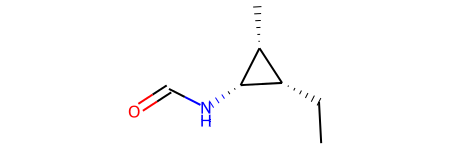

In [12]:
Chem.MolFromSmiles(df.loc[0]['SMILES'])

In [13]:
train_ids, test_ids, valid_ids = train_test_validation_split(molecules=df['SMILES'][:5000], valid_size=0.1, threshold=0.25, no_moving=False, verbose=False)

RDKit WARNING: [11:06:36] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [11:06:36]   BondStereo set to STEREONONE and single bond directions set to NONE.


  0%|          | 0/5000 [00:00<?, ?it/s]

Full graph nr. of edges: 88043
{'0': {'val': 0, 'num': 5000, 'lim': 250}}
250 [250]
Initialization mode slow-nn
1
Currently have this many samples: 5000
!  0 1279 {'metric': 0.7419354838709677}  !
Need to remove! Currently have this many samples: 5000
After removal we have this many samples: 4855


As opposed to biological sequences, for molecules it is less clear what threshold is a sensible choice. This threshold here is just for demonstration purposes and was never validated on any application. We can still plot some molecules to see whether the folds look structurally different.

In [15]:
# shuffle to not just plot initial molecules
import random
random.shuffle(train_ids)
random.shuffle(test_ids)
random.shuffle(valid_ids)

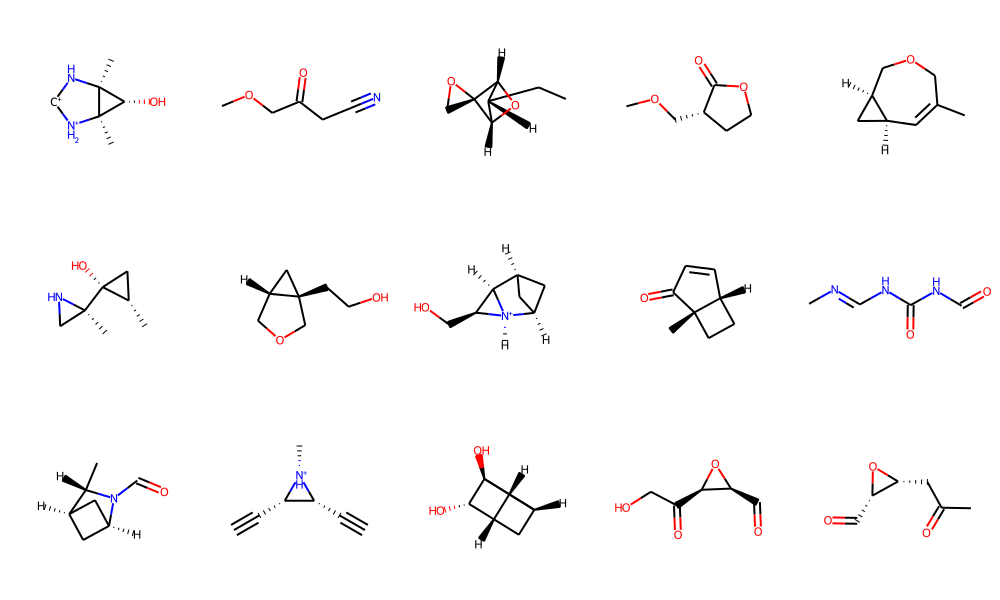

In [16]:
mols = [Chem.MolFromSmiles(x) for x in df.loc[train_ids[:15]]['SMILES']]
Draw.MolsToGridImage(mols, molsPerRow=5)

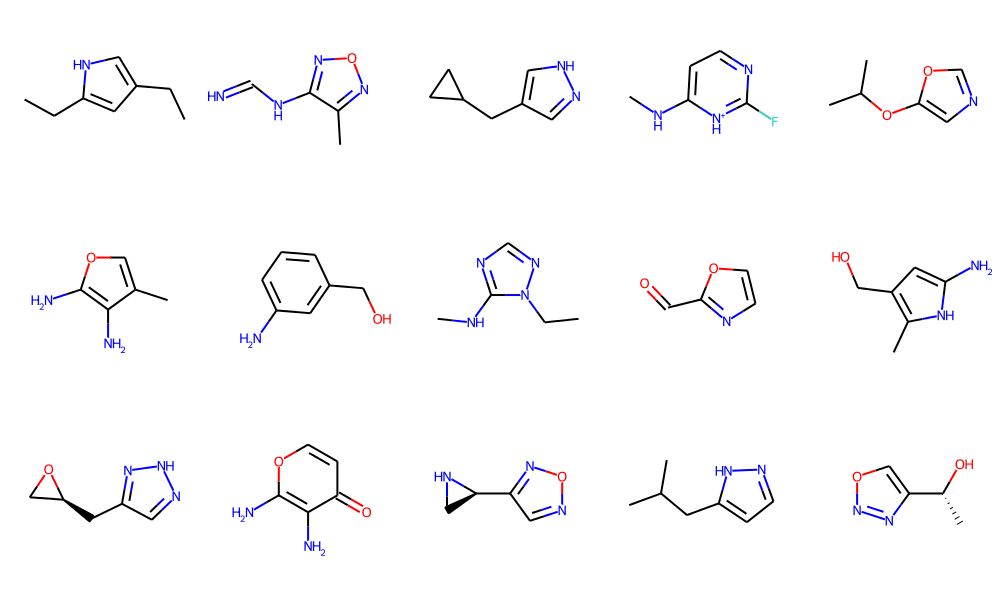

In [17]:
mols = [Chem.MolFromSmiles(x) for x in df.loc[test_ids[:15]]['SMILES']]
Draw.MolsToGridImage(mols, molsPerRow=5)

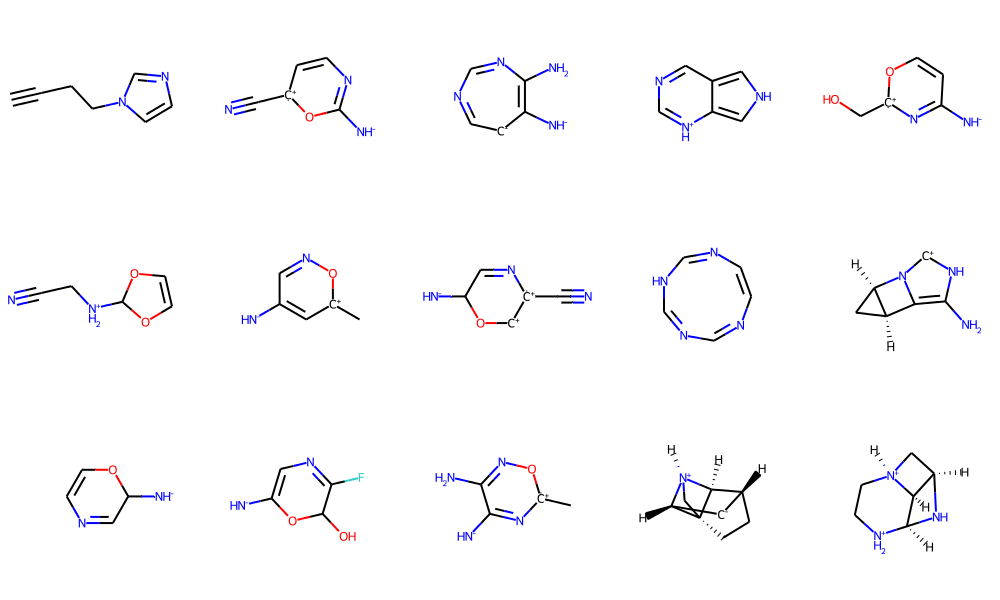

In [18]:
mols = [Chem.MolFromSmiles(x) for x in df.loc[valid_ids[:15]]['SMILES']]
Draw.MolsToGridImage(mols, molsPerRow=5)